# MESA session 3: solution notebook

In [16]:
import os
import numpy as np
import mesa_reader as mr
import matplotlib.pyplot as plt 

import astropy.units as u
import astropy.constants as const


***
# Problem 1:
## Luminosity of Massive Stars at late stages

In [17]:
# Load your computed models (history_data, file)
base = './data/to_C_exhaust/'
masses = [20,30,40]
history_list = [mr.MesaData(os.path.join(base, f'M{m}_DW0_8', 'LOGS', f'M{m}_DW0_8', 'history.data')) for m in masses]

# If you want to check what data is available in the history files, you can use:
# history15.header_names
# history15.bulk_names

In [87]:
# Define a HR diagram plotting function that we can re-use
def HR_diagram(histoy_list, xlim=(None, None), ylim=(None, None), neutrino_luminosity=False,
               Lfrac = True, VMIN=-3, VMAX=0, cmap_name = 'rainbow', colour_by='center_h1', colour_label='kleur',
               save_loc='./plots/'):
    """
    Plot a HR diagram from a list of mesa history data files.
    colour by the fraction of the luminosity from the specified source.
    Lfrac: is the color a fraction of the total luminosity? 
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Function to calc R from stefan-boltzmann law
    def Radius(Teff, L):
        Teff = Teff * u.K
        L = (L * u.Lsun).to(u.W)
        R = (L / (4 * np.pi * const.sigma_sb * Teff**4))**0.5
        return R.to(u.Rsun).value

    # --- Radius contour grid ---
    Teffs = np.linspace(3.5, 8, 100)
    Ls = np.linspace(3.5, 7.0, 100)
    Teffs_grid, Ls_grid = np.meshgrid(Teffs, Ls)
    Radius_grid = Radius(10**Teffs_grid, 10**Ls_grid)
    #
    CS = ax.contour(Teffs_grid, Ls_grid, Radius_grid, levels=[1, 10, 100, 1e3, 1e4], colors='#969696', linestyles='dashed')
    ax.clabel(CS, inline=1, inline_spacing=-5, fontsize=15)


    # --- Plot each star ---     
    for i, hist in enumerate(histoy_list):
        # find where to start the center h drops below 0.69
        start = np.flatnonzero(np.asarray(hist.center_h1) < 0.69)[0] if (np.asarray(hist.center_h1) < 0.69).any() else 0

        # get relevant data from the start of MS to 
        log_Teff = hist.log_Teff[start:] 
        log_L    = hist.log_L[start:] 
        log_Lneu = hist.log_Lneu[start:] 
        log_LH   = hist.log_LH[start:]
        log_LHe  = hist.log_LHe[start:]
        log_LZ   = hist.log_LZ[start:]

        C        = np.asarray(getattr(hist, colour_by)[start:])
        if Lfrac:
            C = C-log_L
        else:
        # I'm coloring by center_c12, which we would like to show in log
            C = np.log10(C) 
        
        # We are either plotting a traditional HR diagram, or neutrino luminosity
        if neutrino_luminosity:
            Y_vals = log_Lneu
        else:
            Y_vals = log_L

        ax.plot(log_Teff, Y_vals, c='k', lw = 1, zorder = 0)
        # colour_by='log_LH' -> 10**log_LH / 10**log_L = L_H / L_tot
        scat = ax.scatter(log_Teff, Y_vals, c=C, cmap = cmap_name, 
        vmin=VMIN, vmax=VMAX, s=20, zorder = 1)

        # Annotate the mass of the star at the start of the MS
        ax.scatter(log_Teff[0], Y_vals[0], marker='*', s=50)
        ax.text(log_Teff[0],  Y_vals[0] , f"${np.round(hist.star_mass[0], 0)}$"+"M$_{\odot}$", ha='right', fontsize = 15) #log_Teff

    cb = plt.colorbar(scat, ax=ax)
    cb.set_label(colour_label if colour_label else (f"{colour_by} / L" if Lfrac else colour_by), fontsize=20)

    # -- Plot values -- 
    ax.set_xlabel('log$_{10}$(T$_{eff}$/K)', fontsize=25)
    ax.set_ylabel('log$_{10}$(L/L$_{\\odot}$)', fontsize=25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    if xlim != (None, None): ax.set_xlim(xlim)
    if ylim != (None, None): ax.set_ylim(ylim)
    ax.invert_xaxis()
    fig.tight_layout()


    plt.savefig(save_loc + "HR_{colour_by}.png", bbox_inches='tight')
    plt.show()


# 1 a)
## H luminosity as a fraction of the total L

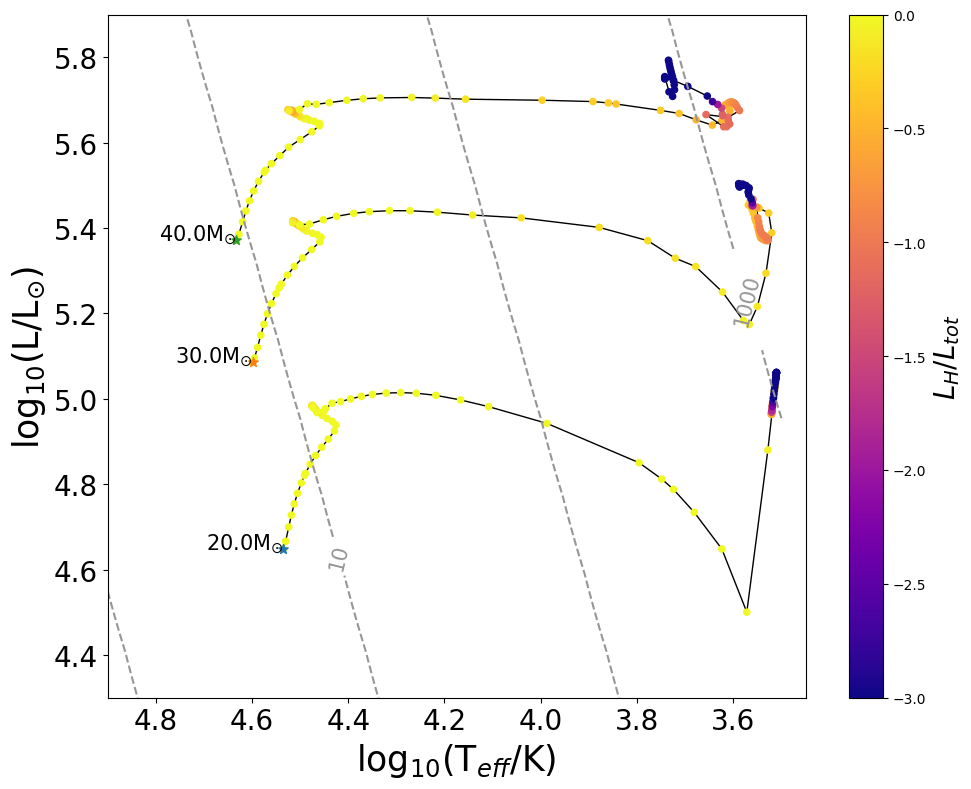

In [88]:
HR_diagram(history_list,
           xlim=(3.45, 4.9), ylim=(4.3, 5.9),
           VMIN=-3, VMAX=0, cmap_name = 'plasma', 
           colour_by='log_LH', colour_label='$L_{H}$/$L_{tot}$')
# center_he4 # center_c12

## He luminosity as a fraction of the total L

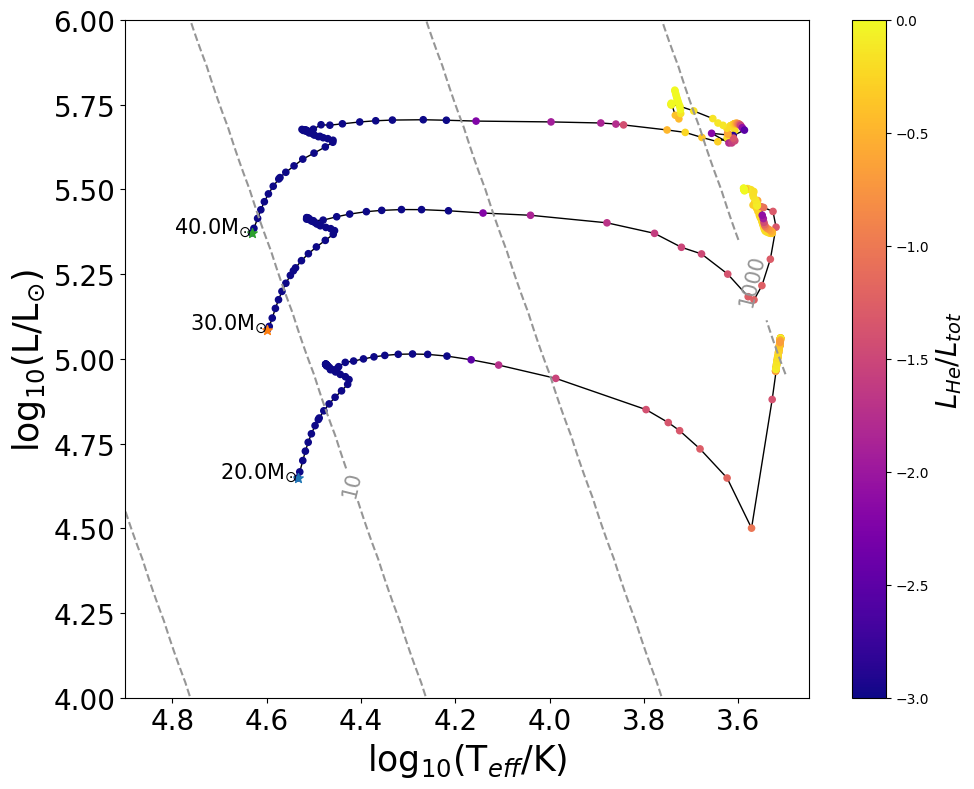

In [89]:
HR_diagram(history_list,
           xlim=(3.45, 4.9), ylim=(4.0, 6.),
           VMIN=-3, VMAX=0, cmap_name = 'plasma', 
           colour_by='log_LHe', colour_label='$L_{He}$/$L_{tot}$')
# center_he4 # center_c12

## Z luminosity as a fraction of the total L

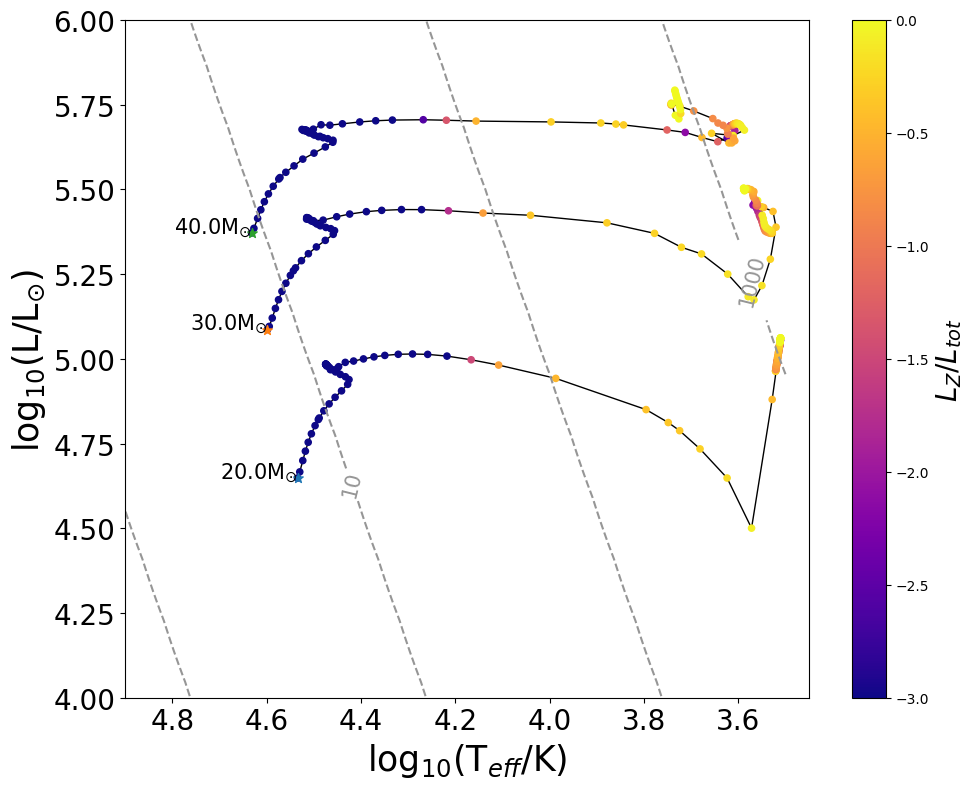

In [90]:
HR_diagram(history_list,
           xlim=(3.45, 4.9), ylim=(4.0, 6.),
           VMIN=-3, VMAX=0, cmap_name = 'plasma', 
           colour_by='log_LZ', colour_label='$L_{Z}$/$L_{tot}$')
# center_he4 # center_c12

# 1 b)
## HR diagram in neutrino luminosity

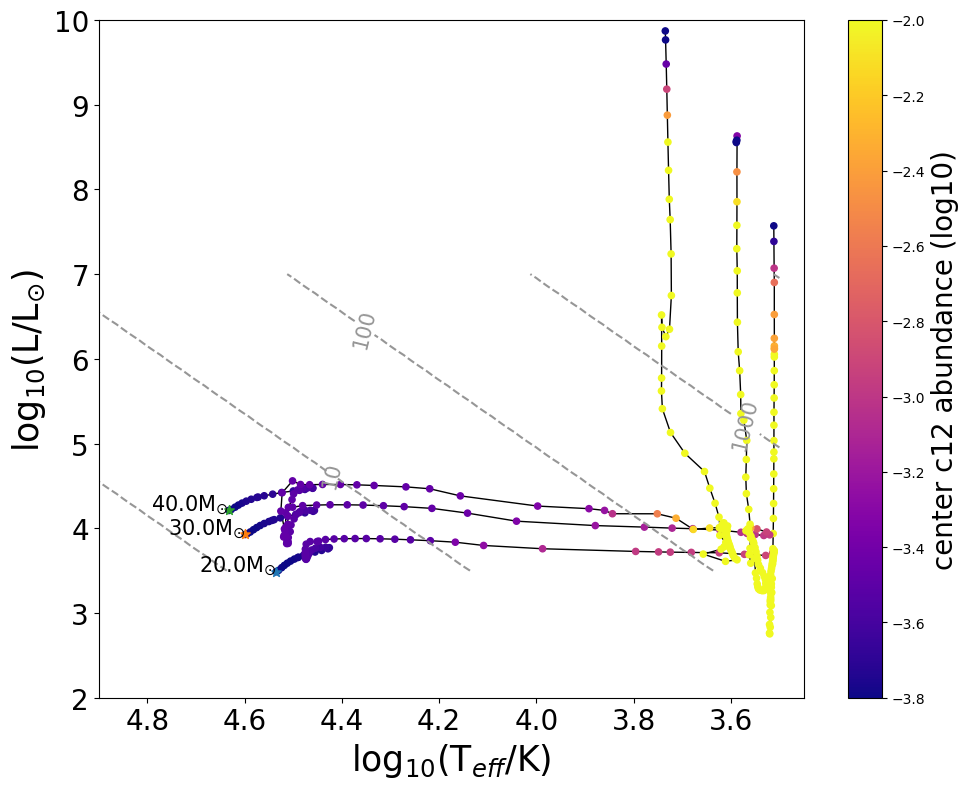

In [94]:
HR_diagram(history_list,neutrino_luminosity = True, 
           xlim=(3.45, 4.9), ylim=(2.0, 10), Lfrac = False, 
           VMIN=-3.8, VMAX=-2, cmap_name = 'plasma',
           colour_by='center_c12', colour_label='center c12 abundance (log10)')


## c) 
We see that hydrogen fusion luminosity dominates during most of the stars path in the HR diagram, due to the MS and H-shell burning phases. 
Helium and metal burning (C burning reactions) only dominate at the very cool side of the HR diagram. L_z starts to contribute before the star has started C ignition in the center: this is due to Carbon + alpha capture in the later stages of He burning.

Most importantly, the neutrino luminosity HR diagram reveals how the late evolution of massive stars is ruled by neutrino emission: the neutrino luminosity of the star at carbon burning (and beyond) is many orders of magnitude larger than the highest photon luminosity the star ever achieves!

***
# 2 Evolution of massive stars with mass loss

In [96]:
var = 'HW3_output_final'
base = f'/Users/liekevanson/Documents/Teaching/ASBE25/data/{var}'

masses = np.arange(15, 45, 5) # 105, 5)
low_DWs = [mr.MesaData( os.path.join(base, f'M{m}_DW0_1', 'LOGS', f'M{m}_DW0_1', 'history.data') ) for m in masses]
mid_DWs = [mr.MesaData( os.path.join(base, f'M{m}_DW0_5', 'LOGS', f'M{m}_DW0_5', 'history.data') ) for m in masses]
high_DWs = [mr.MesaData( os.path.join(base, f'M{m}_DW1_0', 'LOGS', f'M{m}_DW1_0', 'history.data') ) for m in masses]

print('loaded all history.data files')

loaded all history.data files


### PLot all the HR diagrams for these models

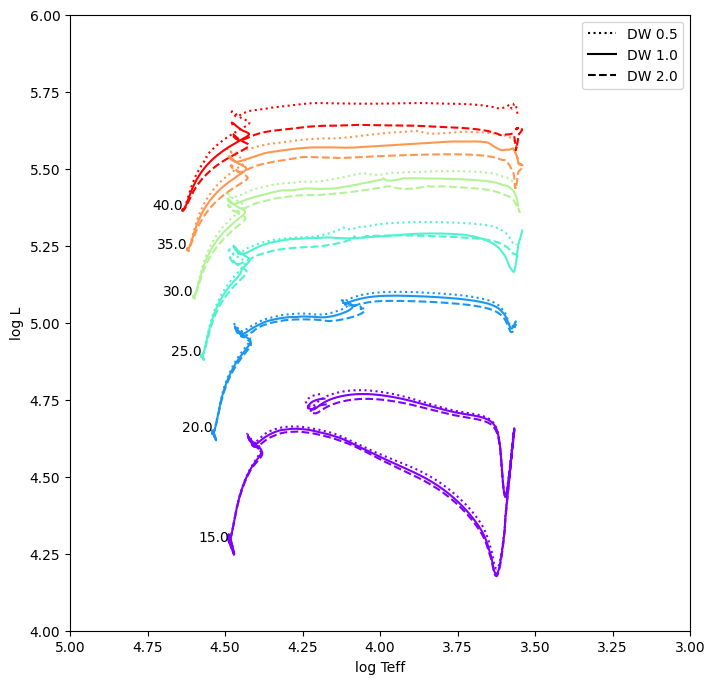

In [99]:
fig, ax = plt.subplots(figsize=(8, 8))

# Use the same colors for all masses
colors = plt.cm.rainbow(np.linspace(0,1,len(low_DWs))) #3rd num is the number of colours Set2

for i in range(len(low_DWs)):
    # star_not_coreHeburng = fid_DWs[i].c_log_eps_burn_tri_alfa < 8
    # plt.plot(fid_DWs[i].log_Teff, fid_DWs[i].log_L,color = colors[i], ls = '-')
    # ax.text(fid_DWs[i].log_Teff[0], fid_DWs[i].log_L[0],f'{np.round(fid_DWs[i].star_mass[0])}', ha = 'right')
 
    plt.plot(low_DWs[i].log_Teff, low_DWs[i].log_L,color = colors[i], ls = ':')
    plt.plot(mid_DWs[i].log_Teff, mid_DWs[i].log_L,color = colors[i], ls = '-')
    plt.plot(high_DWs[i].log_Teff, high_DWs[i].log_L,color = colors[i], ls = '--')

    ax.text(mid_DWs[i].log_Teff[0], mid_DWs[i].log_L[0], f'{np.round(mid_DWs[i].star_mass[0])}', ha = 'right')

plt.plot(-1,-1, c = 'k', label = 'DW 0.5',ls = ':')
plt.plot(-1,-1, c = 'k', label = 'DW 1.0',)
plt.plot(-1,-1, c = 'k', label = 'DW 2.0', ls = '--')

plt.legend()
ax.set_xlabel('log Teff')
ax.set_ylabel('log L')
ax.set_xlim(3, 5)
ax.invert_xaxis()
ax.set_ylim(4,6.)

plt.show()

### Helium abundance versus stellar age

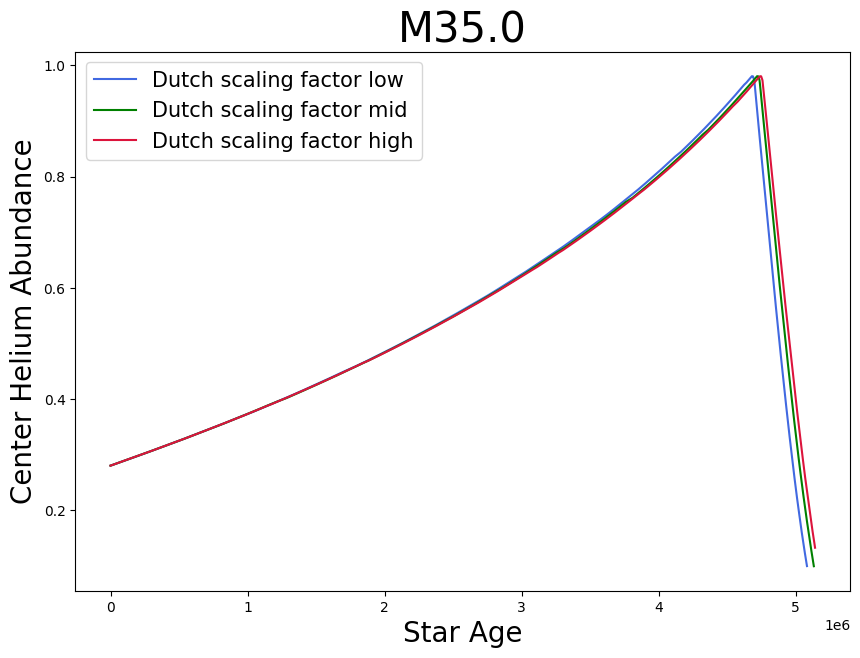

In [106]:
fig, ax = plt.subplots(figsize = (10,7))

mass_index = 4
##########
# Select the data to plot
for histdata, label, colors in zip([low_DWs[mass_index], mid_DWs[mass_index], high_DWs[mass_index]],
                                 ['Dutch scaling factor low', 'Dutch scaling factor mid', 'Dutch scaling factor high'],
                                 ['royalblue', 'green', 'crimson']):
    plt.plot(histdata.star_age, histdata.center_he4, label = label, color = colors)

# 'log_center_T', 'log_center_Rho',
plt.legend(fontsize = 15)
plt.xlabel("Star Age", fontsize = 20 )
plt.ylabel("Center Helium Abundance", fontsize = 20 )
plt.title(f'M{np.round(low_DWs[mass_index].star_mass[0])}', size =30)
plt.savefig('plots/M{}_central_He.png', bbox_inches = 'tight')
plt.show()

Core properties didn't change much when changing the winds (which is an external thing!)

### Plot surface abundances

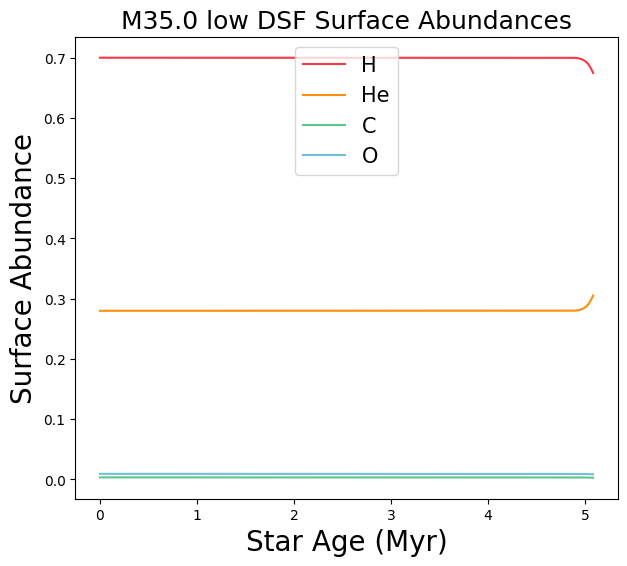

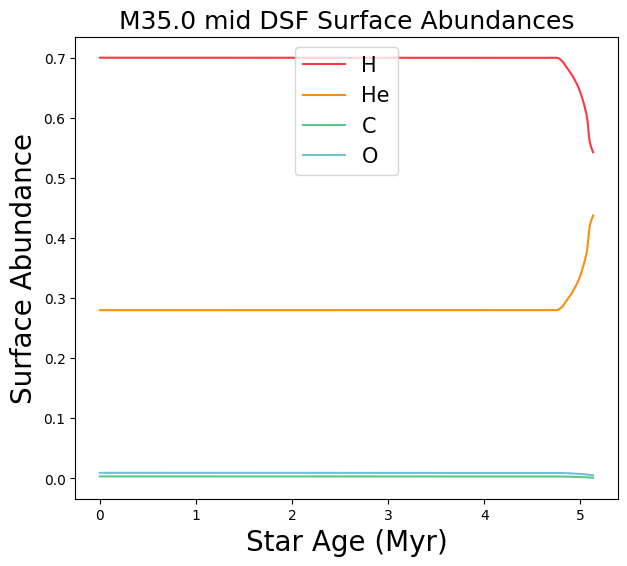

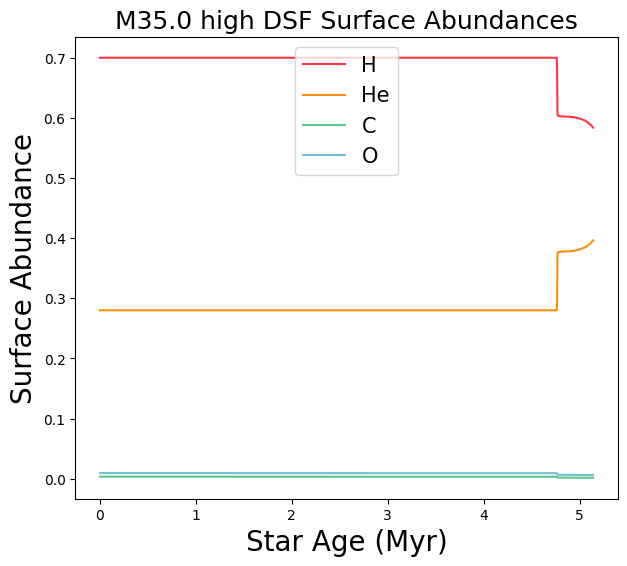

In [107]:
def plot_surface_abundances(histdata, var_name = 'DSF05'):
    fig, ax = plt.subplots(figsize = (7,6))

    ##########
    # Select the data to plot
    plt.plot(histdata.star_age*1e-6, histdata.surface_h1, label = 'H', color = '#FB3743')
    plt.plot(histdata.star_age*1e-6, histdata.surface_he4, label = 'He', color = '#FB8E0C')
    plt.plot(histdata.star_age*1e-6, histdata.surface_c12, label = 'C', color = '#5CC68E')
    plt.plot(histdata.star_age*1e-6, histdata.surface_o16, label = 'O', color = '#71C1D6')

    plt.title(f"M{np.round(histdata.star_mass[0])} {var_name} Surface Abundances", fontsize = 18)
    plt.legend(fontsize = 15)
    plt.xlabel("Star Age (Myr)", fontsize = 20 )
    plt.ylabel("Surface Abundance", fontsize = 20 )
    plt.savefig(f'plots/M_{var_name}_surface_abundances.png', bbox_inches = 'tight')
    plt.show()

mass_index = 4
plot_surface_abundances(low_DWs[mass_index], var_name='low DSF')
plot_surface_abundances(mid_DWs[mass_index], var_name='mid DSF')
plot_surface_abundances(high_DWs[mass_index], var_name='high DSF')



Surface abundances change much more when you change the winds! I.e. with stronger winds, the stars become less H rich and more He rich in their envelope. 

***
# 3 Radius evolution of massive stars

In [133]:
mass_index = 4
history50 = mid_DWs[mass_index]
print(np.round(history50.star_mass[0]))

35.0


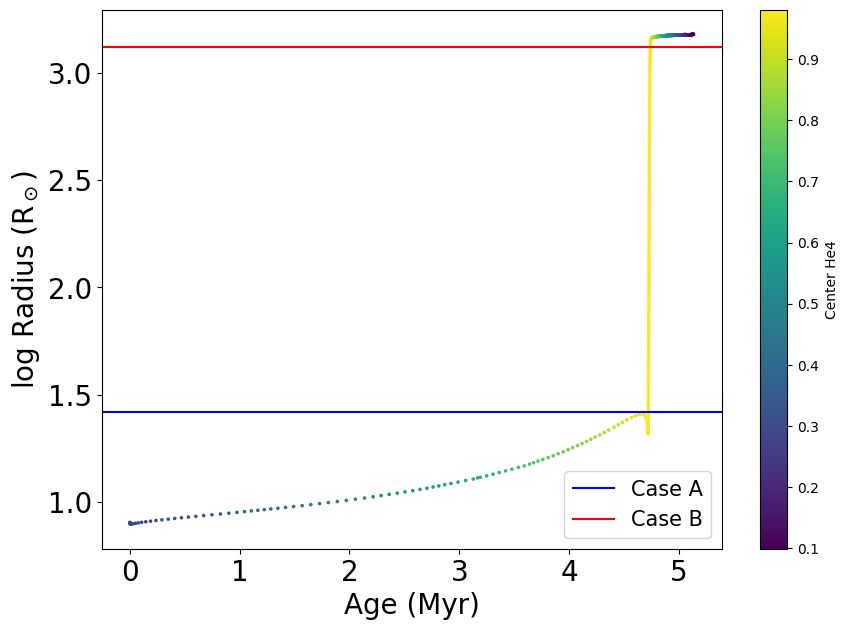

In [138]:
fig, ax = plt.subplots(figsize = (10,7))

plt.scatter(history50.star_age *1e-6, history50.log_R,
            c = history50.center_he4, s = 2.5)

plt.colorbar(label = 'Center He4')
    
plt.axhline(1.42, label = 'Case A', color = 'blue')
plt.axhline(3.12, label = 'Case B', color = 'r')

plt.xlabel('Age (Myr)', fontsize =20)
plt.ylabel('log Radius (R$_\odot$)', fontsize =20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.legend(fontsize = 15)
plt.savefig('plots/Radius_vs_Time.png')

plt.show()  

## b) 
Assuming that the initial separations are distributed flat in log separation, we can directly map the vertical space in logR to the probability of interacting during a certain phase of expansion. 
We see that Case B mass transfer (during the HG) clearly causes the largerst radius increase and is thus the most likely kind of interaction.

In [140]:
print(f"Case A below {10**1.42} Rsun")
print(f"Case B below {10**3.12} Rsun")
print(f"Case C above {10**3.12} Rsun ")


Case A below 26.302679918953814 Rsun
Case B below 1318.2567385564075 Rsun
Case C above 1318.2567385564075 Rsun 


## c) 
Case A is for any radius up to about 25 Rsun, Case B between 25 and about 1300 Rsun and Case C any expansion beyond 1300 Rsun